# Combined Census Total Pop, Census Median Household Income,  NY Times Mask and Covid-19 Data

#### This notebook contains code for gathering Census data tables and converting them to dataframes. 
#### Please use caution when altering this code.

In [2]:
import pandas as pd
from census import Census #<-- Python wrapper for census API
import requests
import os
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import time

# Census API Key
from config import api_key

# provide the api key and the year to establish a session
c = Census(api_key, year=2018)

# Set an option to allow up to 300 characters to print in each column
pd.set_option('max_colwidth', 300)

In [3]:
tables = c.acs5.tables()

# The tables variable contains a list of dicts, so we can convert directly to a dataframe
table_df = pd.DataFrame(tables)

##### The cell below gathering columns names from the Census Total Population table that only contain estimate and are int data types.
##### Those table names are added to a string variable and then pulled from the census data.
##### Dictionary key names are replaced withe more meaningful names.
##### Data is saved to a dataframe and exported as a csv file.

In [4]:
table_id = 'B01003'   

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   


table_columns = ""
for ind in table_info.index:       
    table_columns = table_columns + f"{ind},"
    
    
column_list = table_columns[:-1]
census_data = c.acs5.get(("NAME", column_list), 
                          {'for': 'county:*'})

for i in range(len(table_info)) : 
    for d in census_data:
        d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 
    

census_B01003_TotalPop_df = pd.DataFrame(census_data)
census_B01003_TotalPop_df.to_csv("census_B01003_TotalPop.csv", encoding="utf-8", index=False )
census_B01003_TotalPop_df

Number of available variables: 4


,NAME,state,county,Estimate!!Total
0,"Washington County, Mississippi",28,151,47086.0
1,"Perry County, Mississippi",28,111,12028.0
2,"Choctaw County, Mississippi",28,019,8321.0
3,"Itawamba County, Mississippi",28,057,23480.0
4,"Carroll County, Mississippi",28,015,10129.0
...,...,...,...,...
3215,"Clayton County, Iowa",19,043,17672.0
3216,"Buena Vista County, Iowa",19,021,20260.0
3217,"Guthrie County, Iowa",19,077,10674.0
3218,"Humboldt County, Iowa",19,091,9566.0


### Census Total Population and New York Times Mask Data

In [5]:
census_B01003_TotalPop_df.dtypes

census_B01003_TotalPop_df['COUNTYFP'] = census_B01003_TotalPop_df['state'] + census_B01003_TotalPop_df['county']

census_TotalPop_sorted = census_B01003_TotalPop_df.sort_values(by=['COUNTYFP'])
census_TotalPop_sorted = census_TotalPop_sorted.reset_index(drop=True)

census_TotalPop_sorted['State Name'] = ''
census_TotalPop_sorted['County Name'] = ''


for index, row in census_TotalPop_sorted.iterrows():
    name_all = row['NAME']
    name_list = name_all.split(',')
    clean_state = name_list[1][1:]
    census_TotalPop_sorted.loc[index, 'State Name']= clean_state
    census_TotalPop_sorted.loc[index, 'County Name']= name_list[0]
    
census_TotalPop_sorted.head()

,NAME,state,county,Estimate!!Total,COUNTYFP,State Name,County Name
0,"Autauga County, Alabama",01,001,55200.0,01001,Alabama,Autauga County
1,"Baldwin County, Alabama",01,003,208107.0,01003,Alabama,Baldwin County
2,"Barbour County, Alabama",01,005,25782.0,01005,Alabama,Barbour County
3,"Bibb County, Alabama",01,007,22527.0,01007,Alabama,Bibb County
4,"Blount County, Alabama",01,009,57645.0,01009,Alabama,Blount County


#### Gather New York Times Data

In [6]:
infile = os.path.join("..", "NY_Times_Data", "mask-use-by-county.csv" )
nytimes_mask_data = pd.read_csv(infile)
# nytimes_mask_data.dtypes
nytimes_mask_data['COUNTYFP'] = nytimes_mask_data['COUNTYFP'].astype(str)
nytimes_mask_data['COUNTYFP'] = nytimes_mask_data['COUNTYFP'].str.zfill(5)
nytimes_mask_data.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,01001,0.053,0.074,0.134,0.295,0.444
1,01003,0.083,0.059,0.098,0.323,0.436
2,01005,0.067,0.121,0.120,0.201,0.491
3,01007,0.020,0.034,0.096,0.278,0.572
4,01009,0.053,0.114,0.180,0.194,0.459


#### Merge New York Times and Census Total Population

In [7]:
nytimesmask_census = pd.merge(nytimes_mask_data, census_TotalPop_sorted, on="COUNTYFP", how="left")
nytimesmask_census.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,NAME,state,county,Estimate!!Total,State Name,County Name
0,01001,0.053,0.074,0.134,0.295,0.444,"Autauga County, Alabama",01,001,55200.0,Alabama,Autauga County
1,01003,0.083,0.059,0.098,0.323,0.436,"Baldwin County, Alabama",01,003,208107.0,Alabama,Baldwin County
2,01005,0.067,0.121,0.120,0.201,0.491,"Barbour County, Alabama",01,005,25782.0,Alabama,Barbour County
3,01007,0.020,0.034,0.096,0.278,0.572,"Bibb County, Alabama",01,007,22527.0,Alabama,Bibb County
4,01009,0.053,0.114,0.180,0.194,0.459,"Blount County, Alabama",01,009,57645.0,Alabama,Blount County


#### Gather Means of New York Times Data, Sum of Total Pop Data and create a new dataframe with it. 

In [8]:
nytimesmaskcensus_grouped = nytimesmask_census.groupby(['State Name', 'state'])
nytimesmaskcensus_mean = round(nytimesmaskcensus_grouped.mean(), 3)
nytimesmaskcensus_sum = nytimesmaskcensus_grouped.sum()
nytimesmaskcensus_sum
nytimesmaskcensus_stats = nytimesmaskcensus_mean.drop(columns='Estimate!!Total')

nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'] = nytimesmaskcensus_sum['Estimate!!Total']
# nytimesmaskcensus_stats['NEVER - POP'] = round(nytimesmaskcensus_stats['NEVER'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0) 
# nytimesmaskcensus_stats['RARELY - POP'] = round(nytimesmaskcensus_stats['RARELY'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0)
# nytimesmaskcensus_stats['SOMETIMES - POP'] = round(nytimesmaskcensus_stats['SOMETIMES'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0) 
# nytimesmaskcensus_stats['FREQUENTLY - POP'] = round(nytimesmaskcensus_stats['FREQUENTLY'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0) 
# nytimesmaskcensus_stats['ALWAYS - POP'] = round(nytimesmaskcensus_stats['ALWAYS'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0) 
nytimesmaskcensus_stats = nytimesmaskcensus_stats.reset_index()
nytimesmaskcensus_stats.head()

,State Name,state,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,TOTAL POP (ESTIMATE)
0,Alabama,01,0.082,0.081,0.147,0.215,0.475,4864680.0
1,Alaska,02,0.055,0.063,0.090,0.333,0.459,738516.0
2,Arizona,04,0.050,0.053,0.095,0.147,0.655,6946685.0
3,Arkansas,05,0.091,0.087,0.138,0.221,0.463,2990671.0
4,California,06,0.032,0.031,0.064,0.159,0.715,39148760.0


#### Gather Covid-19 Tracking Project Data

In [9]:
# Save config information.
url = "https://api.covidtracking.com/v1/states/current.json"
covid_json = requests.get(url).json()

In [10]:
states= []
fips = []
deaths= []
covid_positives = []
dates = []

indices = list(range(len(covid_json)))

for i in indices:
    states.append(covid_json[i]['state'])
    fips.append(covid_json[i]['fips'])
    dates.append(covid_json[i]['date'])
    deaths.append(covid_json[i]['death'])
    covid_positives.append(covid_json[i]['positive'])
    
AllStates_dict = {
    "States": states,
    "FIPS": fips,
    "Date": dates,
    "Covid Positive": covid_positives,
    "Deaths": deaths
}
AllStates_df = pd.DataFrame(AllStates_dict )
AllStates_df.head()

,States,FIPS,Date,Covid Positive,Deaths
0,AK,02,20200920,7767,45
1,AL,01,20200920,144962,2437
2,AR,05,20200920,75723,1181
3,AS,60,20200920,0,0
4,AZ,04,20200920,214018,5476


#### Merge Covid Tracking Project Data to NY Times Mask and Census Total Pop Data

In [11]:
mask_covid_data = pd.merge(nytimesmaskcensus_stats, AllStates_df, how="outer", left_on='state', right_on='FIPS')

mask_covid_data
mask_covid_data_clean = mask_covid_data.dropna(axis=0, how='any')
mask_covid_data_clean.head()

,State Name,state,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,TOTAL POP (ESTIMATE),States,FIPS,Date,Covid Positive,Deaths
0,Alabama,01,0.082,0.081,0.147,0.215,0.475,4864680.0,AL,01,20200920,144962,2437
1,Alaska,02,0.055,0.063,0.090,0.333,0.459,738516.0,AK,02,20200920,7767,45
2,Arizona,04,0.050,0.053,0.095,0.147,0.655,6946685.0,AZ,04,20200920,214018,5476
3,Arkansas,05,0.091,0.087,0.138,0.221,0.463,2990671.0,AR,05,20200920,75723,1181
4,California,06,0.032,0.031,0.064,0.159,0.715,39148760.0,CA,06,20200920,778400,14987


### Gather Census Median Household Income Data

In [12]:
table_id = 'B19013'      

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   


table_columns = ""
for ind in table_info.index:       
    table_columns = table_columns + f"{ind},"
    
    
column_list = table_columns[:-1]

census_data = c.acs5.get(("NAME", column_list), 
                          {'for': 'county:*'})

# for i in range(len(table_info)) : 
#     for d in census_data:
#         d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 
    

census_B19013_MHI_df = pd.DataFrame(census_data)
census_B19013_MHI_df.to_csv("census_B19013_MHI.csv", encoding="utf-8", index=False )
census_B19013_MHI_df.head()

Number of available variables: 4


,NAME,B19013_001E,state,county
0,"Washington County, Mississippi",30834.0,28,151
1,"Perry County, Mississippi",39007.0,28,111
2,"Choctaw County, Mississippi",37203.0,28,019
3,"Itawamba County, Mississippi",40510.0,28,057
4,"Carroll County, Mississippi",43060.0,28,015


#### Make changes to Median Household Income Data

In [13]:
census_B19013_MHI_df.dtypes

census_B19013_MHI_df['COUNTYFP'] = census_B19013_MHI_df['state'] + census_B19013_MHI_df['county']

census_MHI_sorted = census_B19013_MHI_df.sort_values(by=['COUNTYFP'])
census_MHI_sorted = census_MHI_sorted.reset_index(drop=True)

census_MHI_sorted['State Name'] = ''
census_MHI_sorted['County Name'] = ''


for index, row in census_MHI_sorted.iterrows():
    name_all = row['NAME']
    name_list = name_all.split(',')
    clean_state = name_list[1][1:]
    census_MHI_sorted.loc[index, 'State Name']= clean_state
    census_MHI_sorted.loc[index, 'County Name']= name_list[0]
    
census_MHI_sorted

,NAME,B19013_001E,state,county,COUNTYFP,State Name,County Name
0,"Autauga County, Alabama",58786.0,01,001,01001,Alabama,Autauga County
1,"Baldwin County, Alabama",55962.0,01,003,01003,Alabama,Baldwin County
2,"Barbour County, Alabama",34186.0,01,005,01005,Alabama,Barbour County
3,"Bibb County, Alabama",45340.0,01,007,01007,Alabama,Bibb County
4,"Blount County, Alabama",48695.0,01,009,01009,Alabama,Blount County
...,...,...,...,...,...,...,...
3215,"Vega Baja Municipio, Puerto Rico",19096.0,72,145,72145,Puerto Rico,Vega Baja Municipio
3216,"Vieques Municipio, Puerto Rico",15539.0,72,147,72147,Puerto Rico,Vieques Municipio
3217,"Villalba Municipio, Puerto Rico",19855.0,72,149,72149,Puerto Rico,Villalba Municipio
3218,"Yabucoa Municipio, Puerto Rico",16013.0,72,151,72151,Puerto Rico,Yabucoa Municipio


####  Merge Median Household Income with existing data

In [14]:
df = census_MHI_sorted.groupby("State Name")["B19013_001E"].median().reset_index()
df_merge = mask_covid_data_clean.merge(df, on=("State Name"))


#### Plot Mask Use versus county & state


ALWAYS
The correlation coefficient (r) is 0.5
The p-value is 0.000166
The r-squared is 0.25
FREQUENTLY
The correlation coefficient (r) is -0.33
The p-value is 0.016612
The r-squared is 0.11
SOMETIMES
The correlation coefficient (r) is -0.62
The p-value is 1e-06
The r-squared is 0.39
RARELY
The correlation coefficient (r) is -0.45
The p-value is 0.00099
The r-squared is 0.2
NEVER
The correlation coefficient (r) is -0.45
The p-value is 0.000934
The r-squared is 0.2


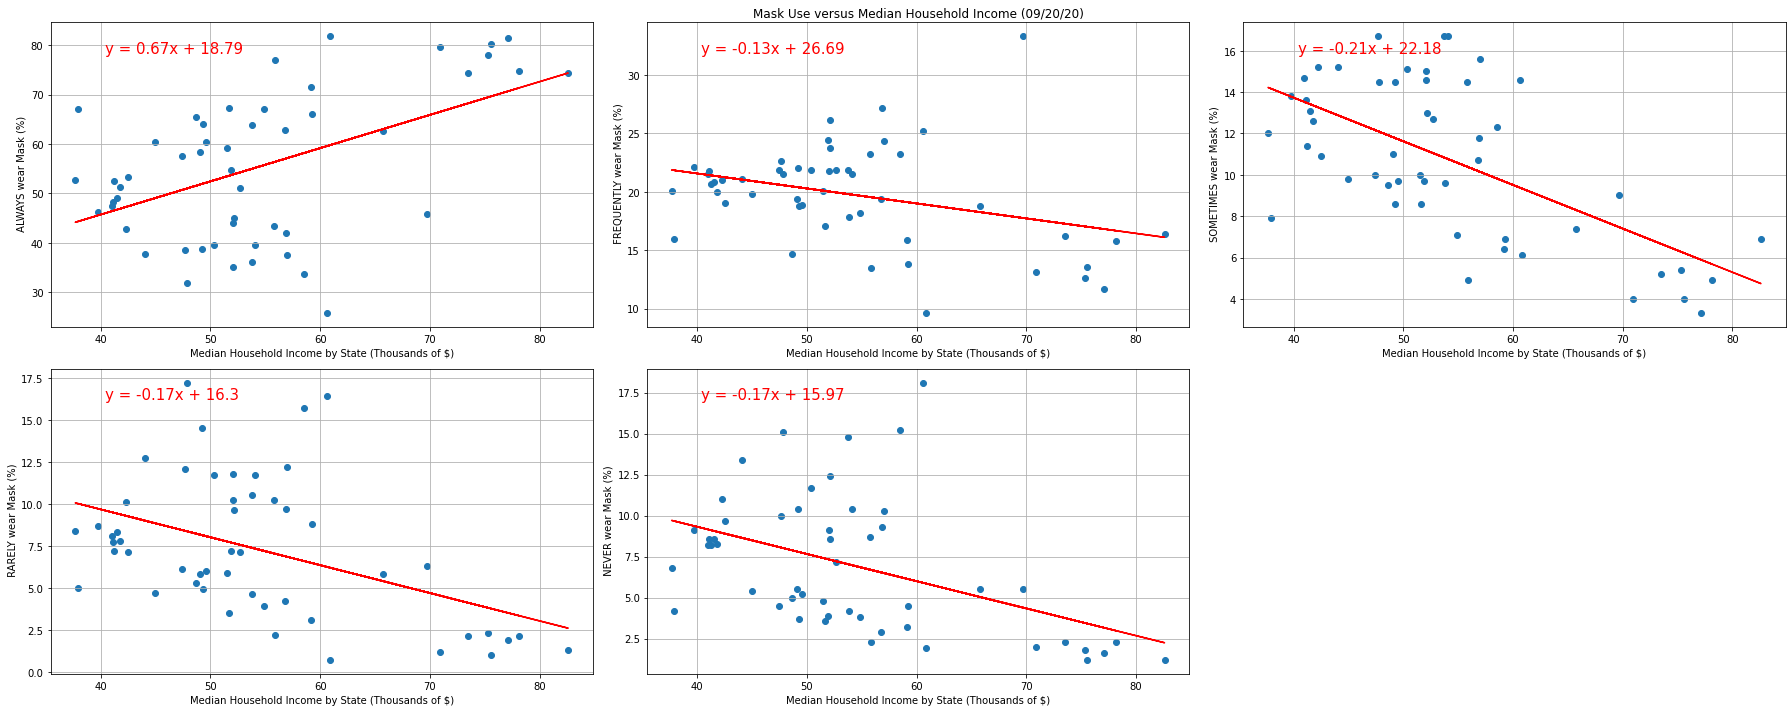

In [26]:
plt.figure(figsize=(25,10))
for i, c in enumerate(["ALWAYS", "FREQUENTLY", "SOMETIMES", "RARELY", "NEVER"]):
     
    
    plt.subplot(2, 3, i+1)
    x = df_merge["B19013_001E"]/1000
    y = df_merge[c] * 100 
    
    plt.scatter(x, y, linewidths=1, marker="o")
    if i==1:
        plt.title("Mask Use versus Median Household Income (%s)" % time.strftime("%x"))
    plt.xlabel("Median Household Income by State (Thousands of $)")
    plt.ylabel(" "+c+" wear Mask (%)")
    plt.grid(True)
    slope, intercept, r_value, p_value, stderr=sts.linregress(x, y)
    plt.plot(x, slope*x+intercept,"r-")
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    print(f"{c}")
    print(f"The correlation coefficient (r) is {round(r_value,2)}")
    print(f"The p-value is {round(p_value,6)}")
    print(f"The r-squared is {round(r_value**2, 2)}")
    
    plt.annotate(line_eq, (0.1, 0.9), fontsize=15, color="red", xycoords= "axes fraction")
    
plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_MaskUsage_Income.png')
plt.savefig(outfile)
